# Домашнее задание
Чем лучше бустить? Тестируем алгоритмы бустинга в бою.

Цель:
В этом домашнем задании вам предстоит провести детективную работу и узнать, какой же алгоритм бустинга работает лучше всего (конечно, применительно к конкретной задаче).

Выберите любой интересующий вас датасет по классификации или регрессии (можно взять из рекозитория https://archive.ics.uci.edu/ml/datasets.php, еще неплохие и востребованные на практике варианты - предсказание оттока пользователей https://www.kaggle.com/blastchar/telco-customer-churn или предсказание Customer Livetime Value (CLV или LTV) - https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data

Data_for_UCI_named - electrical grid stability simulated data - смоделированные данные об устойчивости электрической сети

Attribute Information:

11 predictive attributes, 1 non-predictive(p1), 2 goal fields:
1. tau[x]: reaction time of participant (real from the range [0.5,10]s). Tau1 - the value for electricity producer.
2. p[x]: nominal power consumed(negative)/produced(positive)(real). For consumers from the range [-0.5,-2]s^-2; p1 = abs(p2 + p3 + p4)
3. g[x]: coefficient (gamma) proportional to price elasticity (real from the range [0.05,1]s^-1). g1 - the value for electricity producer.
4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
5. stabf: the stability label of the system (categorical: stable/unstable)

Информация об атрибутах:

11 прогностических атрибутов, 1 непрогностический (p1), 2 поля целей:
1. tau[x]: время реакции участника (реальное из диапазона [0,5,10] с). Tau1 - значение для производителя электроэнергии.
2. p[x]: номинальная потребляемая мощность (отрицательная)/вырабатываемая (положительная) (реальная). Для потребителей из диапазона [-0,5,-2]с^-2; р1 = абс (р2 + р3 + р4)
3. g[x]: коэффициент (гамма), пропорциональный ценовой эластичности (действительный из диапазона [0,05,1]с^-1). g1 - значение для производителя электроэнергии.
4. stab: максимальная действительная часть корня характеристического уравнения (если положительна - система линейно неустойчива)(real)
5. stabf: метка стабильности системы (категория: стабильная/нестабильная)

## target = stabf: метка стабильности системы (категория: стабильная/нестабильная)

In [46]:
pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

import phik #https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

In [48]:
data = pd.read_csv('Data_for_UCI_named.csv')

In [49]:
df = data.copy() #скопирую data в переменую df, чтобы не подгружать data

In [50]:
# удалю stab т.к. делаю классификацию
df.drop(columns = 'stab', inplace = True)

In [51]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable


# Часть 1. EDA
По выбранному датасету проведите EDA, познакомьтесь с признаками, посмотрите зависимости и т.д.

In [52]:
df.shape

(10000, 13)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stabf   10000 non-null  object 
dtypes: float64(12), object(1)
memory usage: 1015.8+ KB


In [54]:
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930


In [55]:
#распределение stabf
stabf_freq = pd.concat([df['stabf'].value_counts(dropna=False).to_frame(name='stabf'), 
           df['stabf'].value_counts(dropna=False, normalize=True).to_frame(name='stabf%')], axis= 1)
stabf_freq

,stabf,stabf%
unstable,6380,0.638
stable,3620,0.362


## Анализ переменных

In [56]:
# пропуки
print(df.isnull().sum())
print(f'всего пропусков: {df.isnull().sum().sum()}')

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stabf    0
dtype: int64
всего пропусков: 0


### Анализ столбцов

In [57]:
df.columns

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stabf'],
      dtype='object')

In [58]:
# колонки по типам
df.dtypes.value_counts()

float64    12
object      1
dtype: int64

In [59]:
#числовые, непрерывные переменныe
columns = df.select_dtypes(['float64']).columns
print(columns)

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4'],
      dtype='object')


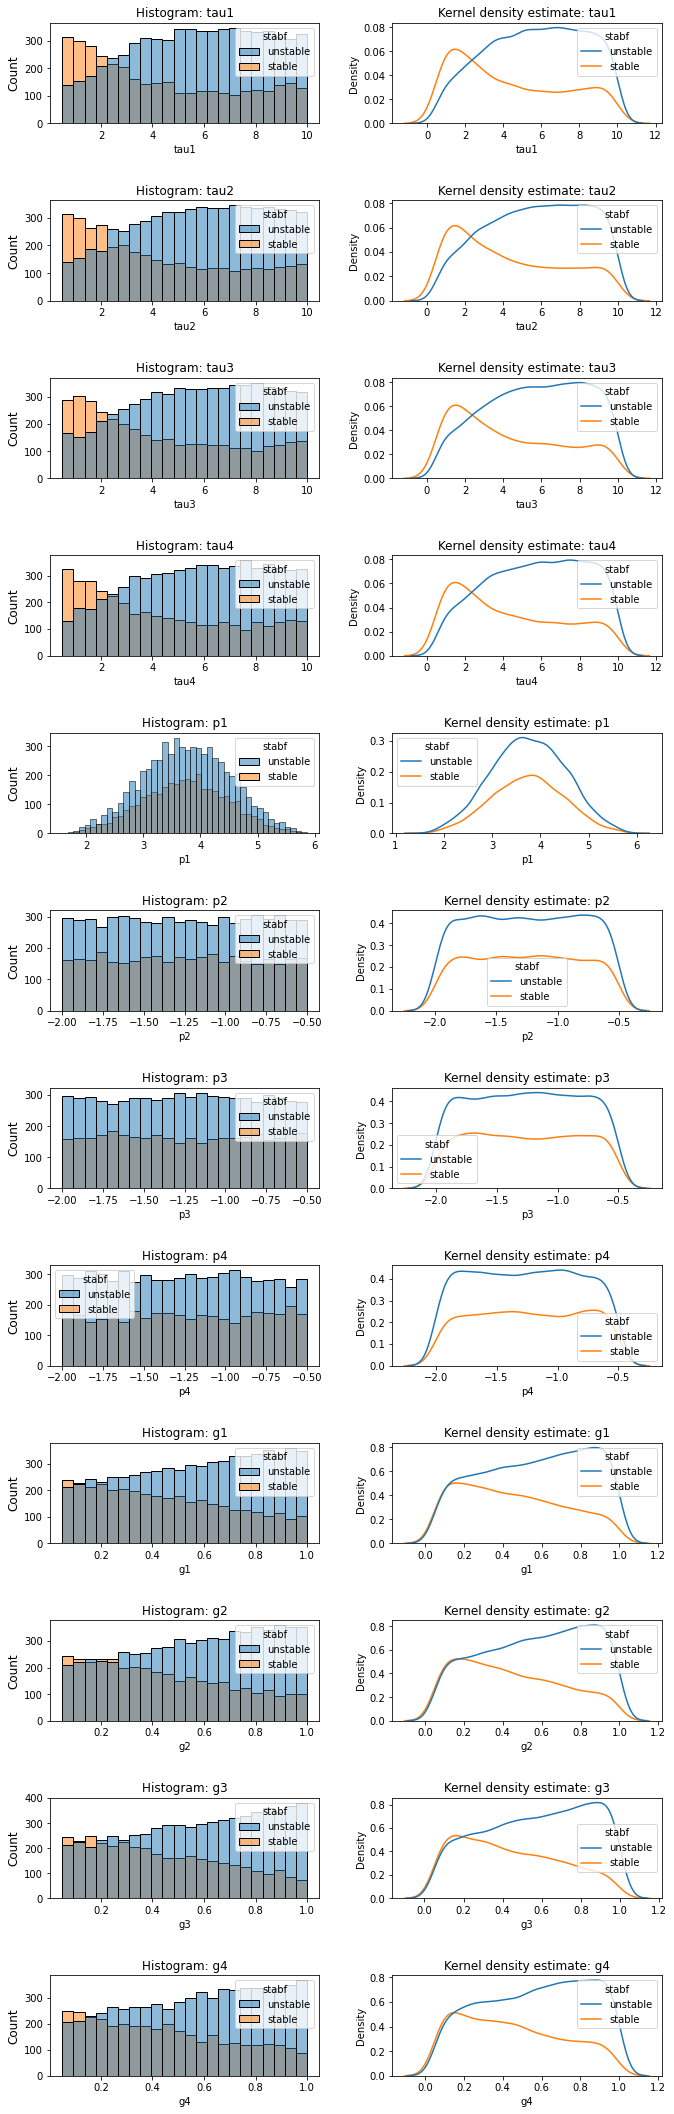

In [60]:
# гистограммы и графики плотности распределения признаков для числовых, непрерывных переменных
# окружение для графиков, для каждой колонки два столбца
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(10,30))

for index, column in enumerate(columns):
    # В первом столбце гистограмма
    sns.histplot(data=df, x=column, hue='stabf', ax=axs[index, 0])
    #df[column].hist(ax=axs[index, 0])
    axs[index, 0].set_title(f'Histogram: {column}', fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)
        
    # Во втором столбце график сглаженной плотности распределения на основе ядерной оценки
    #df[column].plot(kind='kde', ax=axs[index, 1])
    sns.kdeplot(data=df, x=column, hue='stabf', ax=axs[index, 1])
    axs[index, 1].set_title(f'Kernel density estimate: {column}', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

In [61]:
#Заменю stabf: метка стабильности системы (категория: stable = стабильная = 1/unstable = нестабильная = 0)
df.loc[df['stabf'] == 'stable', 'stabf'] = 1
df.loc[df['stabf'] == 'unstable', 'stabf'] = 0

In [62]:
df['stabf'] = df['stabf'].astype('int')

In [63]:
# проверю. распределение stabf
stabf_freq_encoder = pd.concat([df['stabf'].value_counts(dropna=False).to_frame(name='stabf'), 
           df['stabf'].value_counts(dropna=False, normalize=True).to_frame(name='stabf%')], axis= 1)
stabf_freq_encoder

,stabf,stabf%
0,6380,0.638
1,3620,0.362


In [64]:
stabf_freq

,stabf,stabf%
unstable,6380,0.638
stable,3620,0.362


#### stabf_freq = stabf_freq_encoder

In [65]:
corr_list = df.columns
corr_list

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stabf'],
      dtype='object')

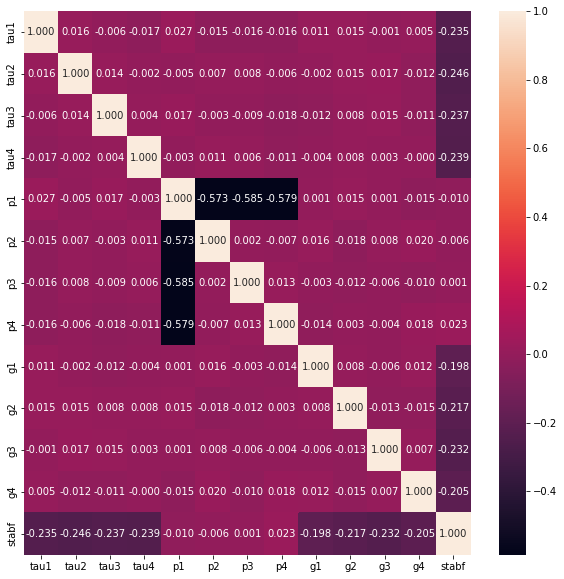

In [66]:
#корреляции

corr = df[corr_list].corr()

# Отобразим ее на тепловой карте
plt.figure(figsize=(10,10));
sns.heatmap(corr, annot=True, fmt='.3f')

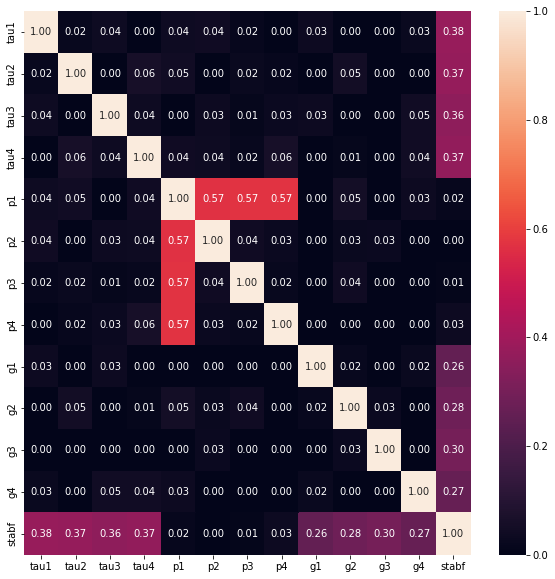

In [67]:
phik_overview = df[corr_list].phik_matrix(interval_cols=corr_list)
plt.figure(figsize=(10,10));
sns.heatmap(phik_overview, annot=True, fmt='.2f')

#### На основе phik метода только 9 атрибутов из набора данных считаются важными или влиятельными для классификации, это следующие атрибуты: tau1	tau2	tau3	tau4	g1	g2	g3	g4 

# Часть 2. Preprocessing & Feature Engineering

In [68]:
# оставлю tau1 tau2 tau3 tau4 g1 g2 g3 g4
drop_list = ['p1', 'p2', 'p3', 'p4']

In [69]:
df.drop(columns = drop_list, inplace=True)

In [70]:
# размерности
for el in df.columns:
    if el == 'stabf':
        continue
    else: 
        print(f'показатель: {el}')
        print(df.groupby('stabf')[el].agg(['mean', 'median', 'count']))

показатель: tau1
           mean    median  count
stabf                           
0      5.735239  5.848943   6380
1      4.394799  3.758877   3620
показатель: tau2
           mean    median  count
stabf                           
0      5.758752  5.886590   6380
1      4.353362  3.715732   3620
показатель: tau3
           mean    median  count
stabf                           
0      5.740601  5.870588   6380
1      4.385360  3.770857   3620
показатель: tau4
           mean    median  count
stabf                           
0      5.744485  5.867834   6380
1      4.378495  3.796595   3620
показатель: g1
           mean    median  count
stabf                           
0      0.565832  0.586484   6380
1      0.453035  0.425106   3620
показатель: g2
           mean    median  count
stabf                           
0      0.569897  0.590298   6380
1      0.445872  0.407890   3620
показатель: g3
           mean    median  count
stabf                           
0      0.572879  0.594452   6

#### размерности разные - буду приводить к одному масштабу

# Часть 3. Моделирование

In [71]:
#зафиксирую random_state
random_state=13

In [72]:
#Сохраним в  𝑋 все колонки признаки, а в  𝑦 − целевую переменную.
X = df.drop('stabf', axis=1)
y = df['stabf']

X.shape, y.shape

((10000, 8), (10000,))

In [73]:
#Разобьем данные на тренировочный и тестовый наборы.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [74]:
# метрики качества буду собирать в дата-фрейм df_metrics. Создам функцию

df_score = pd.DataFrame({"score":["Accuracy", "Precision", "Recall", "F1-score", "AUC"]})
df_score.set_index("score")

def get_df_score(classifier, y_expected, y_predicted, y_predicted_proba):
    accuracy = accuracy_score(y_predicted, y_expected)
    print("Accuracy:  {:.3f}".format(accuracy))

    precision = precision_score(y_predicted, y_expected)
    print("Precision: {:.3f}".format(precision))

    recall = recall_score(y_predicted, y_expected)
    print("Recall:    {:.3f}".format(recall))

    f1 = f1_score(y_predicted, y_expected)
    print("F1-score:  {:.3f}".format(f1))
    
    auc = roc_auc_score(y_expected, y_predicted_proba)
    print("AUC:       {:.3f}".format(auc))
    
    df_score[classifier] = [accuracy, precision, recall, f1, auc]

In [75]:
scaler_list = ['tau1', 'tau2', 'tau3', 'tau4', 'g1', 'g2', 'g3', 'g4'] 

In [76]:
#Приведу к одному масштабу непрерывные признаки
 
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[scaler_list] = scaler.fit_transform(X_train[scaler_list])
X_test_scaled[scaler_list] = scaler.transform(X_test[scaler_list])

### Моделирование из коробки

In [77]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_scaled, y_train)
y_pred = gb_classifier.predict(X_test_scaled)
y_pred_proba = gb_classifier.predict_proba(X_test_scaled)
get_df_score('GradientBoostingClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.919
Precision: 0.841
Recall:    0.923
F1-score:  0.880
AUC:       0.977


In [78]:
# XGBoost

import xgboost as xgb

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_scaled, y_train)
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)
get_df_score('XGBClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.914
Precision: 0.832
Recall:    0.916
F1-score:  0.872
AUC:       0.977


In [79]:
#CatBoost
from catboost import CatBoostClassifier

catboost_classifier = CatBoostClassifier(silent=True)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred = catboost_classifier.predict(X_test_scaled)
y_pred_proba = catboost_classifier.predict_proba(X_test_scaled)
get_df_score('CatBoostClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.951
Precision: 0.913
Recall:    0.947
F1-score:  0.929
AUC:       0.992


In [80]:
#LGBMClassifier

from lightgbm import LGBMClassifier

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train_scaled, y_train)
y_pred = lgbm_classifier.predict(X_test_scaled)
y_pred_proba = lgbm_classifier.predict_proba(X_test_scaled)
get_df_score('LGBMClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.936
Precision: 0.894
Recall:    0.921
F1-score:  0.907
AUC:       0.987


In [81]:
#Результаты
df_score_base = df_score.copy()
df_score_base

,score,GradientBoostingClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier
0,Accuracy,0.919333,0.914333,0.951333,0.935667
1,Precision,0.840607,0.832068,0.912713,0.893738
2,Recall,0.922917,0.916405,0.946850,0.920821
3,F1-score,0.879841,0.872203,0.929469,0.907078
4,AUC,0.977112,0.976638,0.992064,0.987075


#### На данный момент наибольшую точность прогнозирования дает CatBoostClassifier

### Моделирование с настройкой гиперпараметров

In [82]:
#GradientBoostingClassifier
parameters = {
    "n_estimators": stats.randint(10, 1000),
    "learning_rate": stats.uniform(0.01, 1),
    "subsample": stats.uniform(0.5, 1.0),

    "max_depth": stats.randint(3, 10),
    "min_samples_split": stats.randint(3, 20),
    "min_samples_leaf": stats.randint(3, 20)
}

gb_classifier_tuned = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_iter=100, cv=5, n_jobs=-1)
gb_classifier_tuned.fit(X_train_scaled, y_train)

print(gb_classifier_tuned.score(X_train_scaled, y_train))
print(gb_classifier_tuned.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 317, in _check_params
    raise ValueError("subsample must be in (0,1] but was %r" % self.subsample)
ValueError: subsample m

0.9995714285714286
{'learning_rate': 0.058490472056182734, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 509, 'subsample': 0.5497208741644062}


In [83]:
#GradientBoostingClassifier get_df_score
y_pred = gb_classifier_tuned.predict(X_test_scaled)
y_pred_proba = gb_classifier_tuned.predict_proba(X_test_scaled)
get_df_score('GradientBoostingClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.946
Precision: 0.898
Recall:    0.946
F1-score:  0.922
AUC:       0.990


In [84]:
#XGBoost
parameters = {
    'n_estimators': stats.randint(10, 1000),
    'learning_rate': stats.uniform(0.01, 1),
    'subsample': stats.uniform(0.5, 1.0),

    'max_depth': stats.randint(3, 10),
    'gamma': stats.uniform (1, 9),
    'min_child_weight' : stats.randint(0, 10),
    'colsample_bytree': stats.uniform(0.5, 1),
    'reg_alpha': stats.randint(0, 1),
    'reg_lambda': stats.uniform(0, 1),
}

xgb_classifier_tuned = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=100, cv=5, n_jobs=-1)
xgb_classifier_tuned.fit(X_train_scaled, y_train)

print(xgb_classifier_tuned.score(X_train_scaled, y_train))
print(xgb_classifier_tuned.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
410 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 728, in fit
    self._Booster = train(xgb_options, train_dmatrix, self.get_num_boosting_rounds(),
  File "/usr/local/lib/python3.8/dist-packages/xgboost/training.py", line 212, in train
    return _train_internal(params, dtrain,
  File "/usr/lo

1.0
{'colsample_bytree': 0.887091026876777, 'gamma': 1.0834771132324943, 'learning_rate': 0.27342723128494817, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 651, 'reg_alpha': 0, 'reg_lambda': 0.050256372075852096, 'subsample': 0.5367326542480544}


In [85]:
#XGBoost get_df_score
y_pred = xgb_classifier_tuned.predict(X_test_scaled)
y_pred_proba = xgb_classifier_tuned.predict_proba(X_test_scaled)
get_df_score('XGBClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.941
Precision: 0.907
Recall:    0.925
F1-score:  0.916
AUC:       0.988


In [86]:
#CatBoost
parameters = {
    'n_estimators': stats.randint(100, 1000),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.9),

    'depth': stats.randint(3, 13),
    "min_data_in_leaf": stats.randint(1, 10),    
    'l2_leaf_reg': stats.randint(1, 5),
    'random_strength': stats.uniform(0, 3),
    'bagging_temperature': stats.uniform(0.5, 1.0),
    'border_count': [32, 64, 128, 256]
}

catboost_classifier_tuned = RandomizedSearchCV(CatBoostClassifier(silent=True), parameters, 
                                               cv=5, n_jobs=-1)
catboost_classifier_tuned.fit(X_train_scaled, y_train)

print(catboost_classifier_tuned.score(X_train_scaled, y_train))
print(catboost_classifier_tuned.best_params_)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.8/dist-packages/catboost/core.py", line 2339, in _fit
    train

0.9994285714285714
{'bagging_temperature': 0.5589628305077425, 'border_count': 64, 'depth': 4, 'l2_leaf_reg': 4, 'learning_rate': 0.09792821541870121, 'min_data_in_leaf': 7, 'n_estimators': 746, 'random_strength': 2.739795515475743, 'subsample': 0.8312367353847574}


In [87]:
#CatBoost get_df_score
y_pred = catboost_classifier_tuned.predict(X_test_scaled)
y_pred_proba = catboost_classifier_tuned.predict_proba(X_test_scaled)
get_df_score('CatBoostClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.952
Precision: 0.922
Recall:    0.940
F1-score:  0.931
AUC:       0.992


In [88]:
#LGBMClassifier
parameters = {
    "n_estimators": stats.randint(10, 100),
    "learning_rate": stats.uniform(0.01, 1),
    "subsample": stats.uniform(0.5, 1.0),
    
    "max_depth": stats.randint(3, 13),
    "num_leaves": stats.randint(1, 50),
    "min_data_in_leaf": stats.randint(1, 100),    
    "max_bin": stats.randint(3, 50),    
    "boosting_type" : ['gbdt', 'dart'],    
    'reg_alpha': stats.randint(0, 4),
    'reg_lambda': stats.uniform(0, 4)
}

lgbm_classifier_tuned = RandomizedSearchCV(LGBMClassifier(), parameters, n_iter=1000,
                                            scoring='accuracy', cv=5, n_jobs=-1)
lgbm_classifier_tuned.fit(X_train_scaled, y_train)

print(lgbm_classifier_tuned.score(X_train_scaled, y_train))
print(lgbm_classifier_tuned.best_params_)

0.9992857142857143
{'boosting_type': 'gbdt', 'learning_rate': 0.4523265901769187, 'max_bin': 33, 'max_depth': 10, 'min_data_in_leaf': 81, 'n_estimators': 80, 'num_leaves': 20, 'reg_alpha': 1, 'reg_lambda': 3.07751536381425, 'subsample': 0.9302911553182744}


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2595 fits failed out of a total of 5000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2490 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", line 997, in construct
    self._lazy_init(self.data, label=self.label,
  File "/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py", lin

In [89]:
y_pred = lgbm_classifier_tuned.predict(X_test_scaled)
y_pred_proba = lgbm_classifier_tuned.predict_proba(X_test_scaled)
get_df_score('LGBMClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.945
Precision: 0.906
Recall:    0.934
F1-score:  0.920
AUC:       0.988


In [90]:
#Результаты
df_score_tuned = df_score.copy()
df_score_tuned

,score,GradientBoostingClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier,GradientBoostingClassifier_Tuned,XGBClassifier_Tuned,CatBoostClassifier_Tuned,LGBMClassifier_Tuned
0,Accuracy,0.919333,0.914333,0.951333,0.935667,0.946333,0.941333,0.952000,0.944667
1,Precision,0.840607,0.832068,0.912713,0.893738,0.898482,0.907021,0.922201,0.906072
2,Recall,0.922917,0.916405,0.946850,0.920821,0.946054,0.924565,0.940039,0.934442
3,F1-score,0.879841,0.872203,0.929469,0.907078,0.921655,0.915709,0.931034,0.920039
4,AUC,0.977112,0.976638,0.992064,0.987075,0.990251,0.987885,0.991739,0.988247


In [91]:
df_score_base

,score,GradientBoostingClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier
0,Accuracy,0.919333,0.914333,0.951333,0.935667
1,Precision,0.840607,0.832068,0.912713,0.893738
2,Recall,0.922917,0.916405,0.946850,0.920821
3,F1-score,0.879841,0.872203,0.929469,0.907078
4,AUC,0.977112,0.976638,0.992064,0.987075
